## Survival Analysis

This notebook will quickly implement survival analysis (time-to-event analysis) to model the estimated time until a customer churn.

### Data-Preprocessing

First, a bit of data pre-processing. Since exploratory data analysis has been implemented in the Rmarkdown file, this section will keep data pre-processing simple and straight to the point for the analysis.

In [39]:
#Import libraries 
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
#Reading data to a dataframe
df = pd.read_csv("Telco_churn.csv")

In [3]:
#Transforming data as in EDA and modeling parts
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors = 'coerce')
df.TotalCharges.fillna(0, inplace = True) 

In [4]:
#Convert event variable to a binary indicator
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [5]:
#Inspect data format
df.head(5)
for item in df.columns:
    print(item)
    print(df[item].unique())

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender
['Female' 'Male']
SeniorCitizen
[0 1]
Partner
['Yes' 'No']
Dependents
['No' 'Yes']
tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService
['No' 'Yes']
MultipleLines
['No phone service' 'No' 'Yes']
InternetService
['DSL' 'Fiber optic' 'No']
OnlineSecurity
['No' 'Yes' 'No internet service']
OnlineBackup
['Yes' 'No' 'No internet service']
DeviceProtection
['No' 'Yes' 'No internet service']
TechSupport
['No' 'Yes' 'No internet service']
StreamingTV
['No' 'Yes' 'No internet service']
StreamingMovies
['No' 'Yes' 'No internet service']
Contract
['Month-to-month' 'One year' 'Two year']
PaperlessBilling
['Yes' 'No']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (a

### Kaplan-Meier Curve

A kaplan-meier curve serves as an estimator for aggregated-level survival function. 

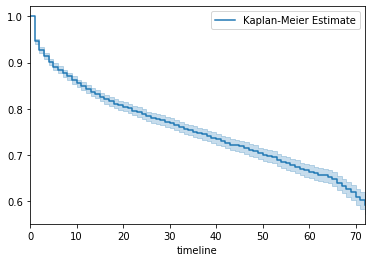

In [6]:
from lifelines import KaplanMeierFitter
#Specify data input for the model
time = df['tenure'] #time unit is in month
event = df['Churn'] 

#Create Kaplan-Meier model
km = KaplanMeierFitter()
km.fit(time, event, label = 'Kaplan-Meier Estimate')
km.plot()

I get a void graph showing the estimated survival function of the data sample. The reason why it is void is it shows a decreasing rate of people surviving as time increases...basically a natural law we all know even before the analysis. Let's try to get something more insightful. E.g., we can perform the estimate on different segments. 

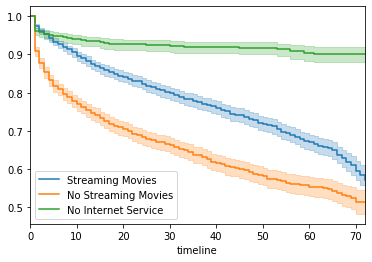

In [7]:
km1 = KaplanMeierFitter()

#Defining segments
group1 = df['StreamingMovies']
seg1 = (group1 == 'Yes')
seg2 = (group1 == 'No')
seg3 = (group1 == 'No internet service')

#Fit models for segments
km1.fit(time[seg1], event[seg1], label = "Streaming Movies")
p1 = km1.plot()

km1.fit(time[seg2], event[seg2], label = "No Streaming Movies")
p2 = km1.plot(ax = p1)

km1.fit(time[seg3], event[seg3], label = "No Internet Service")
km1.plot(ax = p2)

Now we're talking! Once we get segments involved, the analysis gives us more information. As shown in the graph, the survival rate for the segments differ greatly –– segments with no internet service are less likely to churn, those with streaming movies the next, and those without the streaming movies service the most likely to churn. With this new information, the analyst can then look closer to these segments, and try to understand the reason behind and take appropriate actions. Noticeably, just like any other supervisual analysis, a kaplan-meier curve at most serves the exploratory purpose. We will need a more solid method in order to reach any inferential conclusion. 

### COX Hazard Model

When aggregated-level insights can be interesting, individual-level information can allow more specific strategies and actions. A COX Hazard Model can model survival rate based on individual-level features (works like a regression). Here, a COX Hazard model uses hazard rate (the instaneous rate of risk given the sample has survived) as the dependant variable, and a list of interested features as input variables. The model assums that the log-hazard ratio is a linear function of the covariates. 

In [8]:
from lifelines import CoxPHFitter
df_cox = df.loc[:, ['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]

In [9]:
df_dummy = pd.get_dummies(df_cox, drop_first = True)
df_dummy.head(5)

,tenure,Churn,MonthlyCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1,0,29.85,0,0,1,0,0,0,0
1,34,0,56.95,0,1,0,0,1,0,0
2,2,1,53.85,0,1,0,0,1,0,0
3,45,0,42.30,0,1,0,0,0,0,0
4,2,1,70.70,0,0,0,0,1,0,0


In [10]:
cph = CoxPHFitter() 
cph.fit(df_dummy, 'tenure', event_col = 'Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 observations, 5174 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7043
  number of events = 1869
partial log-likelihood = -15182.39
  time fit was run = 2019-06-07 12:36:39 UTC

---
                                 coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
MonthlyCharges                  -0.01      0.99      0.00  -6.13 <0.005     30.06       -0.01       -0.01
SeniorCitizen                    0.40      1.49      0.06   7.16 <0.005     40.15        0.29        0.50
gender_Male                     -0.01      0.99      0.05  -0.23   0.82      0.29       -0.10        0.08
Partner_Yes                     -0.81      0.45      0.05 -14.93 <0.005    164.98       -0.92       -0.70
Dependents_Yes                  -0.36      0.70      0.07  -5.21 <0.005     22.37       -0.49       -0.22
PhoneService_Yes                 0.69      2.00      0.10   6.65 <0.005     34.96        0.49     

Here's the way to interpret the coefficients: with one unit increase in the variable, the hazard ratio tends to increase/decrease by exp(coef). For example, if a customer has a partner, his/her hazard ratio of churning tends to decrease by 55% (1-0.45). 

Just like a linear regression, there are ways to access the goodness of fit of a COX model. One way is to look at CPH score `cph.score_`, the log-likelihood ratio test, or to check the proportional hazard assumptions.

In [11]:
cph.score_

0.7108933879138637

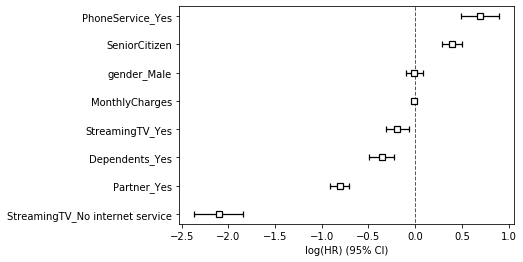

In [12]:
#Plotting covariates coefficient 
cph.plot()

#### Prediction

With an estimate regression model, we can go on to predict hazard ratio and survival function for a censored individual. 

In [29]:
cph = CoxPHFitter().fit(df_dummy, 'tenure','Churn')
censored_subjects = df_dummy.loc[df_dummy['Churn'] == 0]
unconditioned_sf = cph.predict_survival_function(censored_subjects)

In [20]:
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[df_dummy.loc[c.name, 'tenure']]).clip_upper(1))

In [30]:
conditioned_sf

,0,1,3,6,7,9,10,11,12,14,...,7030,7031,7033,7035,7036,7037,7038,7039,7040,7042
T,,,,,,,,,,,,,,,,,,,,,
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000
1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000
2.0,0.986663,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000
3.0,0.975972,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.993381,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000
4.0,0.966193,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.987302,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000
5.0,0.958400,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.982441,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000
6.0,0.953397,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.979311,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000
7.0,0.946899,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.975238,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000
8.0,0.941411,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.971788,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000


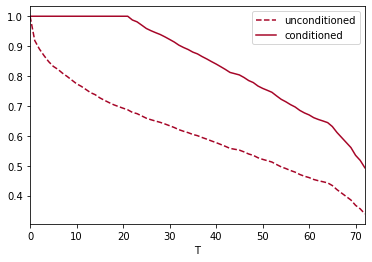

In [40]:
#Plotting survival function for user 14
unconditioned_sf.iloc[:,13].plot(ls="--", color="#A60628", label="unconditioned")
conditioned_sf.iloc[:,13].plot(color="#A60628", label = "conditioned")
plt.legend()

In [49]:
#Estimating event time
from lifelines.utils import median_survival_times, qth_survival_times

predictions_50 = median_survival_times(conditioned_sf)
predictions_75 = qth_survival_times(0.75, conditioned_sf)

predictions_50.iloc[:, 13]
predictions_75.iloc[:, 13]

0.75    52.0
Name: 19, dtype: float64

Assume we are happy with the 75th quantile prediction, we can estimate the lifetime value by multiplying event time with monthly payment.

In [62]:
monthly_payment = df['MonthlyCharges']
monthly_payment = monthly_payment.iloc[predictions_75.columns]

In [63]:
#Obtain lifetime value for censored objects
LTV = predictions_75.multiply(monthly_payment)